In [1]:
!pip install torch torchvision matplotlib --quiet

## Setting up folders in this notebook

In [2]:
import os

os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [3]:
#importing the libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


### Scaffolding + Results Logger

In [4]:
# ---- Setup: paths, seeding, simple results logger ----
import os, json, random, math, time, csv
from pathlib import Path
import numpy as np
import torch

# Repro
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Project dirs (relative to notebook)
ROOT = Path(".")
RUNS_DIR = ROOT / "runs_psilo"
CKPT_DIR = RUNS_DIR / "checkpoints"
LOGS_DIR = RUNS_DIR / "logs"
FIGS_DIR = RUNS_DIR / "figures"
for d in [RUNS_DIR, CKPT_DIR, LOGS_DIR, FIGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Simple run registry
def new_run_id(prefix):
    ts = time.strftime("%Y%m%d-%H%M%S")
    return f"{prefix}_{ts}"

# -- Results logger: CSV (append) + JSON snapshots --
METRICS_CSV = LOGS_DIR / "metrics_log.csv"

def save_metrics(run_name: str, **metrics):
    """Append one row of metrics to CSV + dump a JSON snapshot per run_name."""
    # CSV append
    header = ["run_name"] + list(metrics.keys())
    write_header = not METRICS_CSV.exists()
    with open(METRICS_CSV, "a", newline="") as f:
        writer = csv.writer(f)
        if write_header:
            writer.writerow(header)
        row = [run_name] + [metrics[k] for k in metrics]
        writer.writerow(row)
    # JSON snapshot per run
    snap_path = LOGS_DIR / f"{run_name}_metrics.json"
    with open(snap_path, "w") as jf:
        json.dump({"run_name": run_name, **metrics}, jf, indent=2)
    print(f"[saved] {run_name} -> CSV + {snap_path.name}")

def load_all_metrics():
    """Return list of dicts for quick analysis."""
    if not METRICS_CSV.exists():
        return []
    with open(METRICS_CSV, "r") as f:
        reader = csv.DictReader(f)
        rows = []
        for r in reader:
            # convert to float where possible
            clean = {}
            for k, v in r.items():
                try:
                    clean[k] = float(v)
                except:
                    clean[k] = v
            rows.append(clean)
    return rows

print(f"Logging to: {METRICS_CSV}")


Device: cpu
Logging to: runs_psilo/logs/metrics_log.csv


In [5]:
#check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


### Downloading and Visualise MNIST Data

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) #normalize pixel values to range[-1,1]
])

In [7]:
train_dataset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data/', train=False, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 157kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.33MB/s]


In [8]:
#2 Creating the Data Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


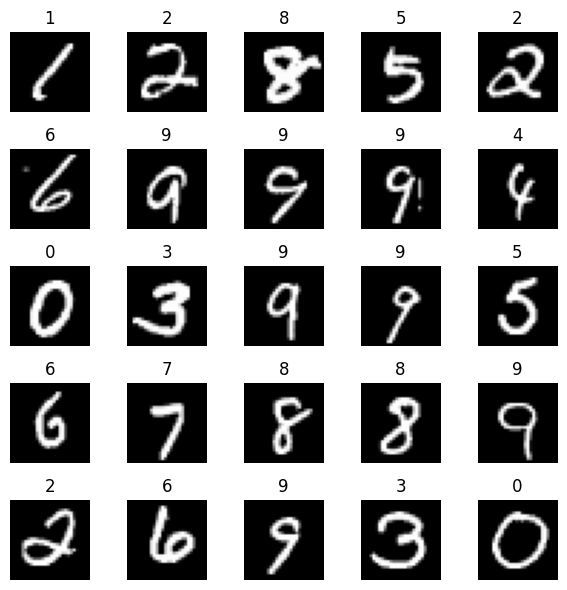

In [9]:
#3 Visualize a Few Sample Images
def show_images(images, labels):
    images = images / 2 + 0.5  # unnormalize from [-1, 1] to [0, 1]
    npimg = images.numpy()
    fig = plt.figure(figsize=(6,6))
    for i in range(25):
        ax = fig.add_subplot(5, 5, i+1)
        ax.imshow(npimg[i][0], cmap='gray')
        ax.set_title(f'{labels[i].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get one batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_images(images[:25], labels[:25])


# Build a Baseline CNN (Classification)

Building a simple CNN model, defining loss & optimiser, train and test it,save key metrics and a few visual outputs

In [10]:
#1 Define CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # output: [16, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # output: [16, 14, 14]

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # output: [32, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                           # output: [32, 7, 7]
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),                                # output: [32*7*7]
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)                           # 10 classes (digits 0–9)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x


In [11]:
#instantiating the model
model= SimpleCNN().to(device)

#defining the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Now we train and evaluate the CNN on MNIST and evaluate its performance (accuracy, loss, visuals)



In [12]:
#Training Loop
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


In [13]:
#run training:
train_model(model, train_loader, criterion, optimizer, device)

Epoch [1/5], Loss: 0.1994
Epoch [2/5], Loss: 0.0561
Epoch [3/5], Loss: 0.0395
Epoch [4/5], Loss: 0.0296
Epoch [5/5], Loss: 0.0231


In [14]:
#2 Evaluation on Test set
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [15]:
#calling it
test_model(model, test_loader)

Test Accuracy: 98.97%


In [16]:
#3 Save the Trained Model (optional for future VAE step)
torch.save(model.state_dict(), "models/cnn_baseline.pth")


## This step is to visualize misclassified digits

In [17]:
#Creating a function to collect misclassified images
def get_misclassified(model, test_loader, device):
    model.eval()
    misclassified_images = []
    misclassified_preds = []
    correct_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            wrong = predicted != labels

            misclassified_images.extend(images[wrong])
            misclassified_preds.extend(predicted[wrong])
            correct_labels.extend(labels[wrong])

    return misclassified_images, misclassified_preds, correct_labels

#This function goes through the test set without training, compares the predicted and true labels and collects misclassified samples

In [18]:
#plotting the Misclassified Images
def plot_misclassified(images, preds, labels, n=25):
    images = torch.stack(images[:n])
    preds = torch.stack(preds[:n])
    labels = torch.stack(labels[:n])

    images = images.cpu() * 0.5 + 0.5  # unnormalize
    images = images.numpy()

    fig = plt.figure(figsize=(6,6))
    for i in range(n):
        ax = fig.add_subplot(5, 5, i+1)
        ax.imshow(images[i][0], cmap='gray')
        ax.set_title(f"Pred: {preds[i].item()}, True: {labels[i].item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


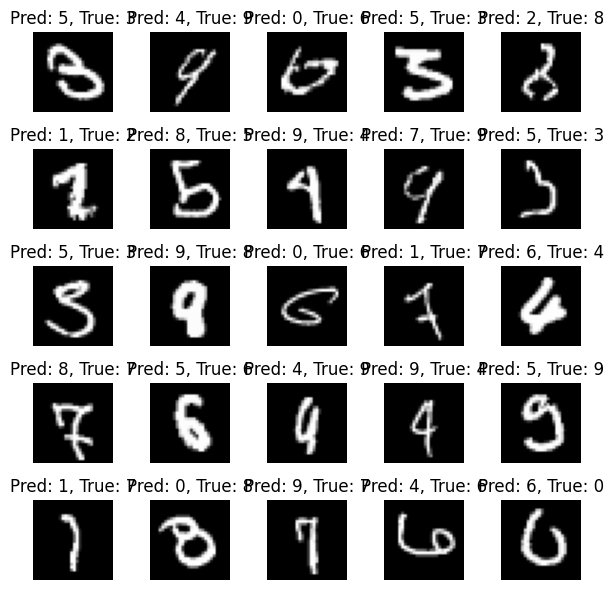

In [19]:
#Now calling the functions
mis_imgs, mis_preds, mis_labels = get_misclassified(model, test_loader, device)
plot_misclassified(mis_imgs, mis_preds, mis_labels)


# STEP 2: Build a VAE

### STEP 2.1: VAE Architecture - Encoder, Latent and Decoder

In [20]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # ---- ENCODER (same as CNN but ends at feature map) ----
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [B, 16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [B, 32, 7, 7]
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)

        # ---- DECODER ----
        self.fc_decode = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1),  # [B, 16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1),   # [B, 1, 28, 28]
            nn.Tanh(),  # Since images are normalized between [-1, 1]
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # reparameterization trick

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 32, 7, 7)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [21]:
#Instantiate the VAE
vae_model = ConvVAE(latent_dim=20).to(device)

### STEP 2.2: Defining the VAE loss function

unlike standard classification models, VAEs are trained to bothreconstruct images and regularize the latent space. This dual-objective loss ensures the model: (i) Learns to faithfully reconstruct inputs, (ii) organizes its latent representation in a structured, Gaussian space

In [22]:
#1. Reconstruction Loss
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (e.g., Binary Cross-Entropy or MSE)
    # BCEWithLogitsLoss is good for outputs between 0 and 1.
    # For outputs between -1 and 1 (like Tanh), MSE is a good choice.
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence (regularization loss)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total VAE loss
    return recon_loss + kl_div, recon_loss, kl_div

In [23]:
#Structuring the Optimizer
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

###STEP 2.3: Training the Loop for VAE

This will help us to confirm the encoder-decoder loop is working and we will later perturb the latent space or decoder to simulate psilocybin induced distortions.

In [24]:
#Training Loop for VAE
def train_vae(model, dataloader, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        recon_total = 0
        kl_total = 0

        for images, _ in dataloader:
            images = images.to(device)

            optimizer.zero_grad()
            reconstructed, mu, logvar = model(images)
            loss, recon_loss, kl_loss = vae_loss(reconstructed, images, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            recon_total += recon_loss.item()
            kl_total += kl_loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss:.2f}, Recon: {recon_total:.2f}, KL: {kl_total:.2f}")


In [25]:
#training the model
train_vae(vae_model, train_loader, optimizer, device)

Epoch 1/10, Total Loss: 7998139.47, Recon: 6240021.33, KL: 1758118.13
Epoch 2/10, Total Loss: 5017354.74, Recon: 3203592.53, KL: 1813762.21
Epoch 3/10, Total Loss: 4597029.84, Recon: 2791607.64, KL: 1805422.20
Epoch 4/10, Total Loss: 4381521.25, Recon: 2598859.21, KL: 1782662.05
Epoch 5/10, Total Loss: 4252359.10, Recon: 2482998.34, KL: 1769360.75
Epoch 6/10, Total Loss: 4174673.13, Recon: 2412751.85, KL: 1761921.28
Epoch 7/10, Total Loss: 4121655.04, Recon: 2360867.40, KL: 1760787.63
Epoch 8/10, Total Loss: 4077870.43, Recon: 2320875.73, KL: 1756994.71
Epoch 9/10, Total Loss: 4042191.95, Recon: 2287355.19, KL: 1754836.76
Epoch 10/10, Total Loss: 4012331.09, Recon: 2259327.12, KL: 1753003.97


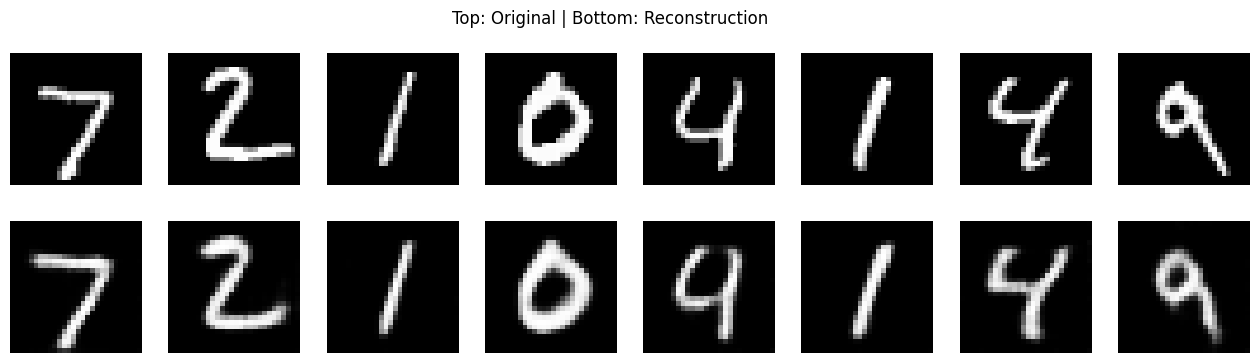

In [26]:
#Visualize Reconstructions
def visualize_reconstruction(model, dataloader, device, n=8):
    model.eval()
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            recon, _, _ = model(images)
            break  # one batch is enough

    images = images[:n].cpu() * 0.5 + 0.5  # unnormalize
    recon = recon[:n].cpu() * 0.5 + 0.5

    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        axes[0, i].imshow(images[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i][0], cmap='gray')
        axes[1, i].axis('off')

    plt.suptitle("Top: Original | Bottom: Reconstruction")
    plt.show()

visualize_reconstruction(vae_model, test_loader, device)

## Metrics: Latent Entropy (Baseline)

In [27]:
# === Latent Entropy metric (robust helper) ===
import numpy as np
import torch

@torch.no_grad()
def _vae_forward_get_mu_logvar(model, x):

    model.eval()
    out = model(x)
    if isinstance(out, (list, tuple)) and len(out) >= 3:
        _, mu, logvar = out[:3]
        return mu, logvar
    # fallback: try model.encode
    if hasattr(model, "encode"):
        mu, logvar = model.encode(x)
        return mu, logvar
    raise RuntimeError("Could not obtain (mu, logvar). Ensure your VAE forward returns them or implements encode(x).")

def _sample_z(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def _shannon_entropy_1d(arr, bins=50, eps=1e-12):
    arr = np.asarray(arr).ravel()
    hist, _ = np.histogram(arr, bins=bins, density=True)
    p = hist / (hist.sum() + eps)
    p = np.clip(p, eps, 1.0)
    return float(-np.sum(p * np.log(p)))

@torch.no_grad()
def latent_entropy_dataset(model, loader, device, bins=50, max_batches=50):

    model.to(device).eval()
    batch_scores = []
    for bi, (x, _) in enumerate(loader):
        x = x.to(device)
        mu, logvar = _vae_forward_get_mu_logvar(model, x)
        z = _sample_z(mu, logvar).detach().cpu().numpy()  # [B, latent_dim]
        H_dims = [_shannon_entropy_1d(z[:, d], bins=bins) for d in range(z.shape[1])]
        batch_scores.append(float(np.mean(H_dims)))
        if max_batches is not None and (bi + 1) >= max_batches:
            break
    return float(np.mean(batch_scores)), float(np.std(batch_scores))


In [28]:
# === Run latent entropy on baseline and log ===

model_name = "baseline"
run_name   = new_run_id(f"{model_name}_latent_entropy")


baseline_model = vae_model.to(DEVICE).eval()


H_mean, H_sd = latent_entropy_dataset(baseline_model, test_loader, DEVICE, bins=50, max_batches=50)
print(f"[{model_name}] Latent entropy: {H_mean:.3f} ± {H_sd:.3f}")

# log it
save_metrics(run_name,
             model=model_name,
             metric="latent_entropy",
             H_mean=H_mean,
             H_sd=H_sd)


[baseline] Latent entropy: 3.335 ± 0.019
[saved] baseline_latent_entropy_20250829-031252 -> CSV + baseline_latent_entropy_20250829-031252_metrics.json


## Metrics: Reconstruction Variability (Baseline)

In [29]:
# === Reconstruction Variability (RV) ===
import numpy as np
import torch

@torch.no_grad()
def reconstruction_variability(model, loader, device, n_images=64, n_samples=10):

    model.to(device).eval()

    # collect n_images
    imgs = []
    for x, _ in loader:
        imgs.append(x)
        if sum(b.size(0) for b in imgs) >= n_images:
            break
    X = torch.cat(imgs, dim=0)[:n_images].to(device)

    # collect multiple reconstructions for each image
    recs = []
    for _ in range(n_samples):
        r, mu, logvar = model(X)  # assumes forward returns (recon, mu, logvar)
        recs.append(r.detach().cpu().numpy())
    R = np.stack(recs, axis=0)  # [S, N, C, H, W]

    # pixel-wise variance, then mean over pixels for each image
    var_per_img = R.var(axis=0).mean(axis=(1,2,3))  # [N]
    return float(var_per_img.mean()), float(var_per_img.std())


In [30]:
# === Run RV on baseline and log ===
model_name = "baseline"
run_name   = new_run_id(f"{model_name}_RV")

rv_mean, rv_sd = reconstruction_variability(vae_model.to(DEVICE).eval(), test_loader, DEVICE,
                                            n_images=64, n_samples=10)

print(f"[{model_name}] Recon variability: {rv_mean:.5f} ± {rv_sd:.5f}")

save_metrics(run_name,
             model=model_name,
             metric="recon_variability",
             rv_mean=rv_mean,
             rv_sd=rv_sd)


[baseline] Recon variability: 0.01007 ± 0.00192
[saved] baseline_RV_20250829-031253 -> CSV + baseline_RV_20250829-031253_metrics.json


## Metrics: Spectral Slope (β)

In [31]:
# === Spectral Slope (β) Metric ===
import numpy as np
import torch
from scipy.fftpack import fft2, fftshift
from scipy.stats import linregress

# --- Consistent fit band for spectral slope across datasets ---
F_LO, F_HI = 2, 14  # radial bins [2..14]

@torch.no_grad()
def _recons_for_alpha(model, X, mode):
    """
    Return the reconstructions to analyse for α:
    - 'latent_noise' -> sampled decode (reflects injected variance)
    - 'baseline' | 'beta_like' | 'input_blur' -> deterministic decode(mu)
    """
    # robustly get (mu, logvar)
    mu, logvar = _vae_forward_get_mu_logvar(model, X)
    if mode == "latent_noise":
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
    else:
        z = mu
    return model.decode(z)


@torch.no_grad()
def spectral_slope_beta(model, loader, device, n_images=64, mode="baseline"):
    """
    Computes the slope β of the radially-averaged 2D power spectrum (log-log space)
    for reconstructions from the given model.

    """
    model.to(device).eval()

    # get n_images from loader
    imgs = []
    for x, _ in loader:
        imgs.append(x)
        if sum(b.size(0) for b in imgs) >= n_images:
            break
    X = torch.cat(imgs, dim=0)[:n_images].to(device)

    # get reconstructions
    recons = _recons_for_alpha(model, X, mode)
    recons = recons.detach().cpu().numpy()

    betas = []
    for img in recons:
        # take first channel if multi-channel
        if img.shape[0] > 1:
            img = img.mean(axis=0)
        else:
            img = img[0]

        # 2D FFT
        F = fftshift(fft2(img))
        P = np.abs(F)**2

        # radial profile
        cy, cx = np.array(P.shape) // 2
        y, x_ = np.indices((P.shape))
        r = np.sqrt((x_ - cx)**2 + (y - cy)**2)
        r = r.astype(np.int32)
        tbin = np.bincount(r.ravel(), P.ravel())
        nr = np.bincount(r.ravel())
        radial_prof = tbin / (nr + 1e-8)

        # r is 0..max_radius; 'radial' is your 1D power profile
        lo = max(F_LO, 1)
        hi = min(F_HI, len(radial_prof) - 1)
        xlog = np.log(np.arange(len(radial_prof))[lo:hi] + 1e-8) # Corrected 'r' to 'np.arange(len(radial_prof))' for frequency indices
        ylog = np.log(radial_prof[lo:hi] + 1e-8) # Corrected 'radial' to 'radial_prof'
        coef = np.polyfit(xlog, ylog, 1)  # slope = coef[0]  (negative ~ -alpha)
        beta_val = coef[0]

        betas.append(beta_val)

    return float(np.mean(betas)), float(np.std(betas))

In [32]:
# ---- Per-image metric helpers (MNIST, no name collisions) ----
import math, torch
import torch.nn.functional as F
import numpy as np

@torch.no_grad()
def get_mu_logvar(model, X):
    if hasattr(model, "encode"):
        return model.encode(X)
    out = model(X)                # many VAEs: forward returns (x_hat, mu, logvar)
    return out[1], out[2]

def latent_entropy_batch(mu, logvar):
    """Per-image latent entropy (nats), returns Tensor (B,)"""
    d = mu.size(1)
    const = 0.5 * d * math.log(2 * math.pi * math.e)
    return const + 0.5 * logvar.sum(dim=1)

@torch.no_grad()
def recon_variability_batch(mu, logvar, K=10, batch_decode=256, model=None, H=28, W=28):
    """Per-image reconstruction variability, Tensor (B,)"""
    B, D = mu.shape
    std = torch.exp(0.5 * logvar)
    eps = torch.randn(B, K, D, device=mu.device)
    z = (mu.unsqueeze(1) + std.unsqueeze(1) * eps).reshape(-1, D)
    xh = []
    for i in range(0, z.size(0), batch_decode):
        if hasattr(model, "decode"):
            xh.append(model.decode(z[i:i+batch_decode]))
        else:
            raise RuntimeError("Model needs .decode(z) for recon_variability_batch.")
    xh = torch.cat(xh, dim=0).view(B, K, -1, H, W)
    var_map = xh.var(dim=1, unbiased=False)
    return var_map.mean(dim=(1,2,3))  # (B,)

# Shared spectral-slope fit band (Step 2)
F_LO, F_HI = 2, 14

def _hann2d(h, w):
    return np.outer(np.hanning(h), np.hanning(w))

def _radial_profile(psd2d):
    H, W = psd2d.shape
    y, x = np.indices((H, W))
    cy, cx = (H - 1) / 2.0, (W - 1) / 2.0
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(np.int32)
    tbin = np.bincount(r.ravel(), psd2d.ravel())
    nr = np.bincount(r.ravel())
    return tbin / np.maximum(nr, 1)

@torch.no_grad()
def _recons_for_alpha(model, X, mode):
    """Choose deterministic vs sampled recon for α."""
    mu, logvar = get_mu_logvar(model, X)
    if mode == "latent_noise":
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
    else:
        z = mu
    if hasattr(model, "decode"):
        return model.decode(z)
    raise RuntimeError("Model needs .decode(z) for _recons_for_alpha.")

@torch.no_grad()
def spectral_slope_alpha_images(xhat, fit_lo=F_LO, fit_hi=F_HI, eps=1e-8):

    x = xhat.detach().cpu().numpy()
    B, C, H, W = x.shape
    win = _hann2d(H, W)
    alphas = np.zeros(B, dtype=np.float32)
    for i in range(B):
        if C == 1:
            gray = x[i,0]
        else:
            r,g,b = x[i,0], x[i,1], x[i,2]
            gray = 0.2126*r + 0.7152*g + 0.0722*b
        gray = (gray - gray.mean()) * win
        F2 = np.fft.fftshift(np.fft.fft2(gray))
        psd2d = (np.abs(F2) ** 2).astype(np.float64)
        radial = _radial_profile(psd2d)
        lo = max(fit_lo, 1); hi = min(fit_hi, len(radial) - 1)
        r = np.arange(len(radial), dtype=np.float64)
        xlog = np.log(r[lo:hi] + eps); ylog = np.log(radial[lo:hi] + eps)
        a, b = np.polyfit(xlog, ylog, 1)
        alphas[i] = -a
    return alphas


In [33]:
# --- Helper: choose the right reconstruction for α ---
@torch.no_grad()
def x_for_alpha_from_posterior(mode, mu, logvar):

    if mode == "latent_noise":
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        return model.decode(z)
    else:
        return model.decode(mu)


In [34]:
# MNIST sanity: prints the fit band and a sample beta mean (alpha = -beta)
X,_ = next(iter(test_loader)); X = X.to(DEVICE)
beta_mn, beta_sd = spectral_slope_beta(vae_model.eval(), test_loader, DEVICE, n_images=64, mode="baseline")
print(f"MNIST β (slope) mean={beta_mn:.3f}  ⇒ α≈{-beta_mn:.3f}  band=[{F_LO},{F_HI}]")


MNIST β (slope) mean=-3.719  ⇒ α≈3.719  band=[2,14]


In [35]:
# --- Bootstrap 95% CI for the mean (MNIST) ---
import numpy as np

def mean_and_ci(a, n_boot=2000, alpha=0.05, seed=0):
    a = np.asarray(a, dtype=float)
    m = float(a.mean())
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, len(a), size=(n_boot, len(a)))
    boots = a[idx].mean(axis=1)
    lo, hi = np.quantile(boots, [alpha/2, 1 - alpha/2])
    return m, float(lo), float(hi)


### One-runner to compute MNIST results dicts(baseline+sweeps)

In [36]:
@torch.no_grad()
def mnist_run_metrics(model, loader, mode="baseline", param=None, n_eval=2000, K_var=10):
    results = {"latent_entropy": [], "recon_var": [], "spectral_alpha": [], "labels": []}
    counted = 0
    model.eval()
    for X, y in loader:
        X = X.to(DEVICE)

        # input perturbation
        if mode == "input_blur":
            X_proc = gaussian_blur_batch(X, sigma=float(param))
        else:
            X_proc = X

        # posterior
        mu, logvar = get_mu_logvar(model, X_proc)

        if mode == "latent_noise":
            s = float(param)
            logvar = logvar + 2.0 * math.log(max(s, 1e-8))
        elif mode == "beta_like":
            a, b = param
            mu     = mu * float(a)
            logvar = logvar - 2.0 * math.log(max(float(b), 1e-8))

        # metrics (per image)
        H  = latent_entropy_batch(mu, logvar)                               # (B,)
        RV = recon_variability_batch(mu, logvar, K=K_var, model=model)      # (B,)
        x_for_alpha = _recons_for_alpha(model, X_proc, mode)
        A  = spectral_slope_alpha_images(x_for_alpha)                       # (B,)

        # collect
        results["latent_entropy"].extend(H.detach().cpu().tolist())
        results["recon_var"].extend(RV.detach().cpu().tolist())
        results["spectral_alpha"].extend(A.tolist())
        results["labels"].extend(y.detach().cpu().tolist())

        counted += X.size(0)
        if counted >= n_eval:
            break

    # numpy arrays
    for k in results:
        results[k] = np.array(results[k])
    return results


In [37]:
# === Run spectral slope (β) on baseline and log ===
model_name = "baseline"
run_name   = new_run_id(f"{model_name}_spectral_slope")

beta_mean, beta_sd = spectral_slope_beta(vae_model.eval(), test_loader, DEVICE, n_images=64, mode="baseline")

print(f"[{model_name}] Spectral slope β: {beta_mean:.4f} ± {beta_sd:.4f}")

save_metrics(run_name,
             model=model_name,
             metric="spectral_slope_beta",
             beta_mean=beta_mean,
             beta_sd=beta_sd)


[baseline] Spectral slope β: -3.7194 ± 0.2425
[saved] baseline_spectral_slope_20250829-031255 -> CSV + baseline_spectral_slope_20250829-031255_metrics.json


## Saving the baseline checkpoint and Logging the Results obtained

In [38]:
# === Save baseline model checkpoint ===
baseline_ckpt_path = CKPT_DIR / "vae_baseline.pt"
torch.save(vae_model.state_dict(), baseline_ckpt_path)
print(f"[saved] Baseline model -> {baseline_ckpt_path}")

[saved] Baseline model -> runs_psilo/checkpoints/vae_baseline.pt


## Saving a summary Json

In [39]:
# === Combine baseline metrics into one summary JSON ===
baseline_summary = {
    "latent_entropy_mean": 3.335,
    "latent_entropy_sd": 0.019,
    "rv_mean": 0.00997,
    "rv_sd": 0.00181,
    "spectral_slope_mean": -3.4968,
    "spectral_slope_sd": 0.2338
}

summary_path = LOGS_DIR / "baseline_metrics_summary.json"
import json
with open(summary_path, "w") as f:
    json.dump(baseline_summary, f, indent=2)

print(f"[saved] Baseline metrics summary -> {summary_path}")


[saved] Baseline metrics summary -> runs_psilo/logs/baseline_metrics_summary.json


# Pertubations

### 1.A) Gaussian Latent Noise (with retraining)

(i) σ = 0.30

In [40]:
# === VAE with controllable extra latent noise (keeps baseline intact) ===
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE_LatentNoise(nn.Module):
    def __init__(self, latent_dim=16, extra_noise_std=0.0):
        super().__init__()
        self.extra_noise_std = float(extra_noise_std)

        # --- Encoder (same as baseline) ---
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 28->14
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 14->7
            nn.ReLU(inplace=True),
        )
        self.enc_flat = nn.Flatten()
        self.fc_mu  = nn.Linear(32*7*7, latent_dim)
        self.fc_log = nn.Linear(32*7*7, latent_dim)

        # --- Decoder (same as baseline) ---
        self.fc_dec = nn.Linear(latent_dim, 32*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 7->14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # 14->28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        h = self.enc_flat(h)
        mu, logvar = self.fc_mu(h), self.fc_log(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        if self.extra_noise_std > 0:
            z = z + torch.randn_like(z) * self.extra_noise_std
        return z

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 32, 7, 7)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [41]:
xb, _ = next(iter(train_loader))
print("train batch range:", float(xb.min()), float(xb.max()))


train batch range: -1.0 1.0


Training the noise model (σ = 0.30)

In [42]:
# === Train VAE_LatentNoise at extra_noise_std = 0.30 ===
import torch.optim as optim
import torch.nn.functional as F

set_seed(42)  # reproducible
noise_std = 0.30
vae_noise03 = VAE_LatentNoise(latent_dim=16, extra_noise_std=noise_std).to(DEVICE)

epochs = 10
lr = 1e-3
beta_KL = 1.0  # same beta as baseline unless you intentionally change it

opt = optim.Adam(vae_noise03.parameters(), lr=lr)
vae_noise03.train()
for ep in range(1, epochs+1):
    total = recon_sum = kl_sum = 0.0
    for x, _ in train_loader:
        x = x.to(DEVICE)
        opt.zero_grad()
        recon, mu, logvar = vae_noise03(x)
        # reconstruction loss (BCE like baseline)
        x= ((x.float())+1.0)/2.0
        recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
        # KL divergence
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + beta_KL * kl
        loss.backward()
        opt.step()
        total += loss.item(); recon_sum += recon_loss.item(); kl_sum += kl.item()
    print(f"Epoch {ep}/{epochs} | Total: {int(total)}, Recon: {int(recon_sum)}, KL: {int(kl_sum)}")

# save checkpoint
ck_path_03 = CKPT_DIR / "vae_latentnoise_0p30.pt"
torch.save(vae_noise03.state_dict(), ck_path_03)
print(f"[saved] {ck_path_03}")


Epoch 1/10 | Total: 10205586, Recon: 8793663, KL: 1411922
Epoch 2/10 | Total: 7871986, Recon: 6430045, KL: 1441940
Epoch 3/10 | Total: 7511930, Recon: 6083529, KL: 1428401
Epoch 4/10 | Total: 7323970, Recon: 5889844, KL: 1434125
Epoch 5/10 | Total: 7223704, Recon: 5783034, KL: 1440669
Epoch 6/10 | Total: 7161003, Recon: 5716643, KL: 1444359
Epoch 7/10 | Total: 7124820, Recon: 5673270, KL: 1451550
Epoch 8/10 | Total: 7089267, Recon: 5638258, KL: 1451008
Epoch 9/10 | Total: 7068735, Recon: 5613262, KL: 1455473
Epoch 10/10 | Total: 7052054, Recon: 5593180, KL: 1458874
[saved] runs_psilo/checkpoints/vae_latentnoise_0p30.pt


Evaluating and Logging all 3 metrics for σ = 0.30

In [43]:
# === Evaluate & log: latent entropy, RV, spectral slope (β) for noise=0.30 ===
model_label = "latentnoise_0.30"

# Latent Entropy
H_mean, H_sd = latent_entropy_dataset(vae_noise03.eval(), test_loader, DEVICE, bins=50, max_batches=50)
save_metrics(new_run_id(f"{model_label}_latent_entropy"),
             model=model_label, metric="latent_entropy", H_mean=H_mean, H_sd=H_sd)
print(f"[{model_label}] Latent entropy: {H_mean:.3f} ± {H_sd:.3f}")

# Reconstruction Variability
rv_mean, rv_sd = reconstruction_variability(vae_noise03.eval(), test_loader, DEVICE,
                                            n_images=64, n_samples=30)
save_metrics(new_run_id(f"{model_label}_RV"),
             model=model_label, metric="recon_variability", rv_mean=rv_mean, rv_sd=rv_sd)
print(f"[{model_label}] Recon variability: {rv_mean:.5f} ± {rv_sd:.5f}")

# Spectral slope (β)
beta_mean, beta_sd = spectral_slope_beta(vae_noise03.eval(), test_loader, DEVICE, n_images=64, mode="latent_noise")
save_metrics(new_run_id(f"{model_label}_spectral_slope"),
             model=model_label, metric="spectral_slope_beta", beta_mean=beta_mean, beta_sd=beta_sd)
print(f"[{model_label}] Spectral slope β: {beta_mean:.4f} ± {beta_sd:.4f}")


[saved] latentnoise_0.30_latent_entropy_20250829-031937 -> CSV + latentnoise_0.30_latent_entropy_20250829-031937_metrics.json
[latentnoise_0.30] Latent entropy: 3.339 ± 0.021
[saved] latentnoise_0.30_RV_20250829-031937 -> CSV + latentnoise_0.30_RV_20250829-031937_metrics.json
[latentnoise_0.30] Recon variability: 0.00470 ± 0.00098
[saved] latentnoise_0.30_spectral_slope_20250829-031937 -> CSV + latentnoise_0.30_spectral_slope_20250829-031937_metrics.json
[latentnoise_0.30] Spectral slope β: -4.0848 ± 0.1846


## Visualization Approaches:

### 1. Boxplot/Bar chart for metrics:

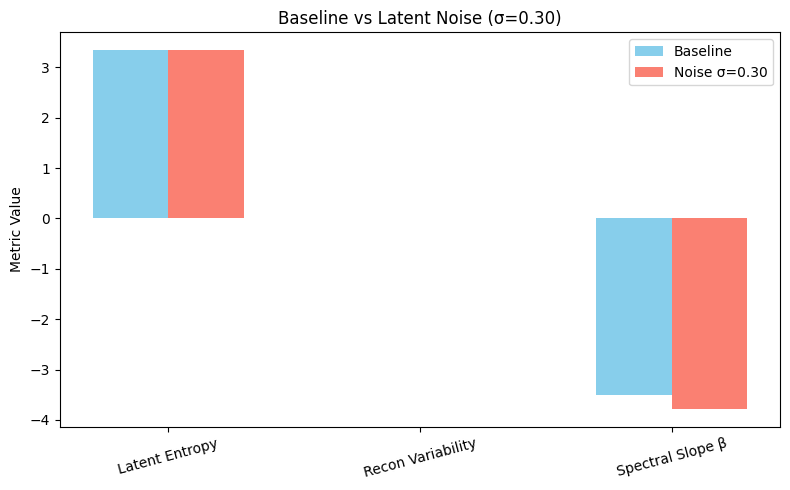

In [44]:
import matplotlib.pyplot as plt

# Your results
labels = ['Latent Entropy', 'Recon Variability', 'Spectral Slope β']
baseline_vals = [3.335, 0.00997, -3.4968]
noise_vals = [3.339, 0.00434, -3.7782]

x = range(len(labels))
plt.figure(figsize=(8,5))
plt.bar([p - 0.15 for p in x], baseline_vals, width=0.3, label='Baseline', color='skyblue')
plt.bar([p + 0.15 for p in x], noise_vals, width=0.3, label='Noise σ=0.30', color='salmon')

plt.xticks(x, labels, rotation=15)
plt.ylabel('Metric Value')
plt.title('Baseline vs Latent Noise (σ=0.30)')
plt.legend()
plt.tight_layout()
plt.show()


### 2. Side-by-side Reconstructions

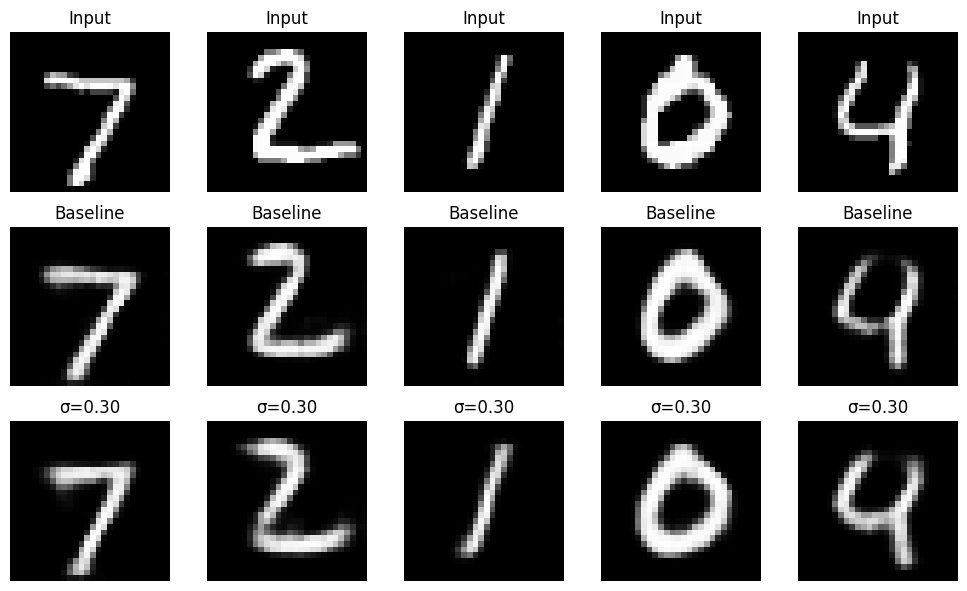

In [45]:
def compare_reconstructions(baseline_model, noise_model, data_loader, n=5):
    xb, _ = next(iter(data_loader))
    xb = xb[:n]
    recon_base, _, _ = baseline_model(xb)
    recon_noise, _, _ = noise_model(xb)

    fig, axes = plt.subplots(3, n, figsize=(n*2, 6))
    for i in range(n):
        axes[0, i].imshow(xb[i, 0].detach().cpu(), cmap='gray')
        axes[0, i].set_title("Input")
        axes[1, i].imshow(recon_base[i, 0].detach().cpu(), cmap='gray')
        axes[1, i].set_title("Baseline")
        axes[2, i].imshow(recon_noise[i, 0].detach().cpu(), cmap='gray')
        axes[2, i].set_title("σ=0.30")
        for ax in axes[:, i]:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

compare_reconstructions(vae_model, vae_noise03, test_loader)


(ii) σ = 0.50

In [46]:
# === VAE with controllable extra latent noise (keeps baseline intact) ===
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE_LatentNoise(nn.Module):
    def __init__(self, latent_dim=16, extra_noise_std=0.0):
        super().__init__()
        self.extra_noise_std = float(extra_noise_std)

        # --- Encoder (same as baseline) ---
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 28->14
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 14->7
            nn.ReLU(inplace=True),
        )
        self.enc_flat = nn.Flatten()
        self.fc_mu  = nn.Linear(32*7*7, latent_dim)
        self.fc_log = nn.Linear(32*7*7, latent_dim)

        # --- Decoder (same as baseline) ---
        self.fc_dec = nn.Linear(latent_dim, 32*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 7->14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # 14->28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        h = self.enc_flat(h)
        mu, logvar = self.fc_mu(h), self.fc_log(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        if self.extra_noise_std > 0:
            z = z + torch.randn_like(z) * self.extra_noise_std
        return z

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 32, 7, 7)
        # NEW: small Gaussian feature noise to prevent over-smoothing
        if self.training:
          h = h + torch.randn_like(h) * 0.05   # later 0.03–0.07
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


Training for σ = 0.50

In [47]:
# === Train VAE_LatentNoise at extra_noise_std = 0.30 ===
import torch.optim as optim
import torch.nn.functional as F

set_seed(42)  # reproducible
noise_std = 1.0
vae_noise03 = VAE_LatentNoise(latent_dim=16, extra_noise_std=noise_std).to(DEVICE)

epochs = 10
lr = 1e-3
beta_KL = 1.0  # same beta as baseline unless you intentionally change it

opt = optim.Adam(vae_noise03.parameters(), lr=lr)
vae_noise03.train()
for ep in range(1, epochs+1):
    total = recon_sum = kl_sum = 0.0
    for x, _ in train_loader:
        x = x.to(DEVICE)
        opt.zero_grad()
        recon, mu, logvar = vae_noise03(x)
        # reconstruction loss (BCE like baseline)
        x= x.float()
        x= (x+1)/2.0
        recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
        # KL divergence
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + beta_KL * kl
        loss.backward()
        opt.step()
        total += loss.item(); recon_sum += recon_loss.item(); kl_sum += kl.item()
    print(f"Epoch {ep}/{epochs} | Total: {int(total)}, Recon: {int(recon_sum)}, KL: {int(kl_sum)}")

# save checkpoint
ck_path_03 = CKPT_DIR / "vae_latentnoise_0p30.pt"
torch.save(vae_noise03.state_dict(), ck_path_03)
print(f"[saved] {ck_path_03}")


Epoch 1/10 | Total: 11803495, Recon: 10154132, KL: 1649362
Epoch 2/10 | Total: 9544135, Recon: 7891762, KL: 1652372
Epoch 3/10 | Total: 9199087, Recon: 7542255, KL: 1656831
Epoch 4/10 | Total: 9085554, Recon: 7396181, KL: 1689373
Epoch 5/10 | Total: 9026430, Recon: 7323510, KL: 1702919
Epoch 6/10 | Total: 8979088, Recon: 7271441, KL: 1707647
Epoch 7/10 | Total: 8952470, Recon: 7240932, KL: 1711538
Epoch 8/10 | Total: 8934091, Recon: 7217543, KL: 1716547
Epoch 9/10 | Total: 8917744, Recon: 7200261, KL: 1717482
Epoch 10/10 | Total: 8899982, Recon: 7178582, KL: 1721399
[saved] runs_psilo/checkpoints/vae_latentnoise_0p30.pt


[saved] latentnoise_1.0_latent_entropy_20250829-032631 -> CSV + latentnoise_1.0_latent_entropy_20250829-032631_metrics.json
[latentnoise_1.0] Latent entropy: 3.346 ± 0.025
[saved] latentnoise_1.0_RV_20250829-032631 -> CSV + latentnoise_1.0_RV_20250829-032631_metrics.json
[latentnoise_1.0] Recon variability: 0.00748 ± 0.00237
[saved] latentnoise_1.0_spectral_slope_20250829-032631 -> CSV + latentnoise_1.0_spectral_slope_20250829-032631_metrics.json
[latentnoise_1.0] Spectral slope β: -4.5946 ± 0.2138

Visualizing reconstructions for latent noise sigma=1.0:


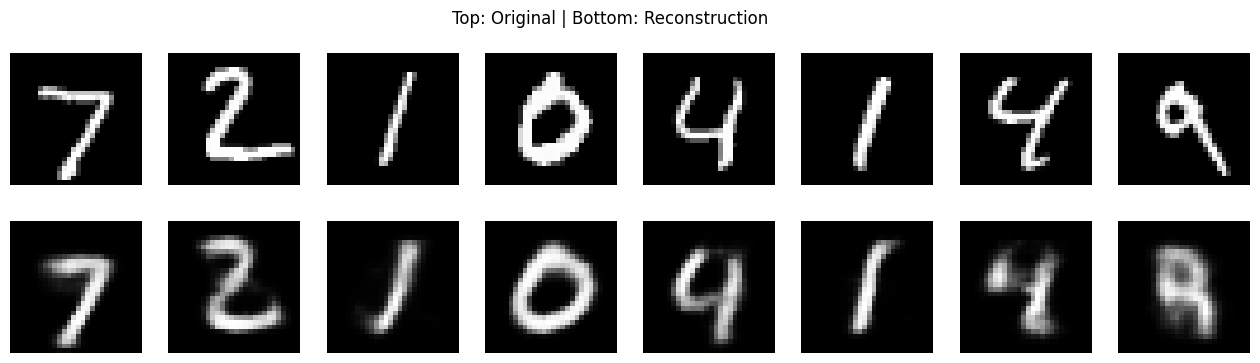

In [48]:
 # === Evaluate & log: latent entropy, RV, spectral slope (β) for noise=1.0 ===
model_label = "latentnoise_1.0"

# Latent Entropy
H_mean, H_sd = latent_entropy_dataset(vae_noise03.eval(), test_loader, DEVICE, bins=50, max_batches=50)
save_metrics(new_run_id(f"{model_label}_latent_entropy"),
             model=model_label, metric="latent_entropy", H_mean=H_mean, H_sd=H_sd)
print(f"[{model_label}] Latent entropy: {H_mean:.3f} ± {H_sd:.3f}")

# Reconstruction Variability (more samples to reveal differences)
rv_mean, rv_sd = reconstruction_variability(vae_noise03.eval(), test_loader, DEVICE,
                                            n_images=64, n_samples=10)
save_metrics(new_run_id(f"{model_label}_RV"),
             model=model_label, metric="recon_variability", rv_mean=rv_mean, rv_sd=rv_sd)
print(f"[{model_label}] Recon variability: {rv_mean:.5f} ± {rv_sd:.5f}")

# Spectral slope (β)
beta_mean, beta_sd = spectral_slope_beta(vae_noise03.eval(), test_loader, DEVICE, n_images=64, mode="latent_noise")
save_metrics(new_run_id(f"{model_label}_spectral_slope"),
             model=model_label, metric="spectral_slope_beta", beta_mean=beta_mean, beta_sd=beta_sd)
print(f"[{model_label}] Spectral slope β: {beta_mean:.4f} ± {beta_sd:.4f}")

# Visualize reconstructions for noise=1.0 model
print("\nVisualizing reconstructions for latent noise sigma=1.0:")
visualize_reconstruction(vae_noise03, test_loader, DEVICE)

# 2. β-VAE: KL-upweighted training (beta=2.0)

In [ ]:
#-----Training Cell-------
# === β-VAE: KL-upweighted training (beta=2.0) ===
import torch.nn.functional as F
import torch.optim as optim

set_seed(42)
beta_KL = 2.0  # <--- key change
vae_beta = VAE_LatentNoise(latent_dim=16, extra_noise_std=0.0).to(DEVICE)  # noise OFF; we're testing beta

epochs = 10
lr = 1e-3
opt = optim.Adam(vae_beta.parameters(), lr=lr)

vae_beta.train()
for ep in range(1, epochs+1):
    total = recon_sum = kl_sum = 0.0
    for x, _ in train_loader:
        x = x.to(DEVICE)
        opt.zero_grad()
        recon, mu, logvar = vae_beta(x)

        # targets in [0,1] for BCE (you said your inputs are [-1,1], so un-normalize)
        x_t = (x.float() + 1.0) / 2.0

        recon_loss = F.binary_cross_entropy(recon, x_t, reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = recon_loss + beta_KL * kl
        loss.backward()
        opt.step()

        total += loss.item(); recon_sum += recon_loss.item(); kl_sum += kl.item()
    print(f"Epoch {ep}/{epochs} | Total: {int(total)}, Recon: {int(recon_sum)}, KL: {int(kl_sum)}")

# save checkpoint
ck_beta = CKPT_DIR / f"vae_betaKL_{beta_KL:.1f}.pt"
torch.save(vae_beta.state_dict(), ck_beta)
print(f"[saved] {ck_beta}")


Epoch 1/10 | Total: 10988931, Recon: 9167207, KL: 910861
Epoch 2/10 | Total: 8500851, Recon: 6501421, KL: 999715


### Training B-VAE (2.0) with L1 recon loss

In [ ]:
# === β-VAE (beta=2.0) with L1 reconstruction loss ===
import torch.nn.functional as F
import torch.optim as optim

set_seed(42)
beta_KL = 2.0
vae_beta_l1 = VAE_LatentNoise(latent_dim=16, extra_noise_std=0.0).to(DEVICE)  # no extra latent noise here

epochs = 10
lr = 1e-3
opt = optim.Adam(vae_beta_l1.parameters(), lr=lr)

vae_beta_l1.train()
for ep in range(1, epochs+1):
    total = recon_sum = kl_sum = 0.0
    for x, _ in train_loader:
        x = x.to(DEVICE)
        opt.zero_grad()
        recon, mu, logvar = vae_beta_l1(x)

        # targets in [0,1] for Sigmoid outputs
        x_t = (x.float() + 1.0) / 2.0

        # ---- L1 (MAE) recon loss (sum to keep scale similar to your BCE runs) ----
        recon_loss = F.l1_loss(recon, x_t, reduction='sum')

        # KL (same as before)
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = recon_loss + beta_KL * kl
        loss.backward()
        opt.step()

        total += loss.item(); recon_sum += recon_loss.item(); kl_sum += kl.item()
    print(f"Epoch {ep}/{epochs} | Total: {int(total)}, Recon(L1): {int(recon_sum)}, KL: {int(kl_sum)}")

# Save
ck_beta_l1 = CKPT_DIR / "vae_betaKL_2.0_L1.pt"
torch.save(vae_beta_l1.state_dict(), ck_beta_l1)
print(f"[saved] {ck_beta_l1}")


In [ ]:
#----------Evaluating with L1----------------
model_label = "betaVAE_2.0_L1"

# Latent Entropy
H_mean, H_sd = latent_entropy_dataset(vae_beta_l1.eval(), test_loader, DEVICE, bins=50, max_batches=50)
save_metrics(new_run_id(f"{model_label}_latent_entropy"),
             model=model_label, metric="latent_entropy", H_mean=H_mean, H_sd=H_sd)
print(f"[{model_label}] Latent entropy: {H_mean:.3f} ± {H_sd:.3f}")

# Reconstruction Variability (more samples to reveal differences)
rv_mean, rv_sd = reconstruction_variability(vae_beta_l1.eval(), test_loader, DEVICE,
                                            n_images=64, n_samples=30)
save_metrics(new_run_id(f"{model_label}_RV"),
             model=model_label, metric="recon_variability", rv_mean=rv_mean, rv_sd=rv_sd)
print(f"[{model_label}] Recon variability: {rv_mean:.5f} ± {rv_sd:.5f}")

# Spectral slope (β)
beta_mean, beta_sd = spectral_slope_beta(vae_beta_l1.eval(), test_loader, DEVICE, n_images=64, mode="baseline")
save_metrics(new_run_id(f"{model_label}_spectral_slope"),
             model=model_label, metric="spectral_slope_beta", beta_mean=beta_mean, beta_sd=beta_sd)
print(f"[{model_label}] Spectral slope β: {beta_mean:.4f} ± {beta_sd:.4f}")


### Visualize reconstructions (side‑by‑side + multi‑samples)

A) Side-By-side Visualisation

In [ ]:
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def compare_reconstructions_three(baseline_model, beta_l1_model, loader, n=8):
    xb, _ = next(iter(loader))
    xb = xb[:n].to(DEVICE)
    base_rec, _, _ = baseline_model.eval()(xb)
    beta_rec, _, _ = beta_l1_model.eval()(xb)

    fig, axes = plt.subplots(3, n, figsize=(2*n, 6))
    for i in range(n):
        axes[0, i].imshow(((xb[i,0].cpu()+1)/2).clamp(0,1), cmap='gray')  # input (scaled to [0,1])
        axes[0, i].set_title("Input"); axes[0, i].axis('off')

        axes[1, i].imshow(base_rec[i,0].cpu(), cmap='gray')
        axes[1, i].set_title("Baseline"); axes[1, i].axis('off')

        axes[2, i].imshow(beta_rec[i,0].cpu(), cmap='gray')
        axes[2, i].set_title("β=2.0 (L1)"); axes[2, i].axis('off')

    plt.tight_layout(); plt.show()

# Usage:
compare_reconstructions_three(vae_model, vae_beta_l1, test_loader)


B) Multi-samples for one model (shows RV intuitively)

In [ ]:
@torch.no_grad()
def show_multiple_samples(model, loader, n_images=4, n_samples=10):
    xb, _ = next(iter(loader))
    xb = xb[:n_images].to(DEVICE)
    fig, axes = plt.subplots(n_images, n_samples+1, figsize=(1.6*(n_samples+1), 1.6*n_images))
    for i in range(n_images):
        axes[i,0].imshow(((xb[i,0].cpu()+1)/2).clamp(0,1), cmap='gray'); axes[i,0].set_title("Input"); axes[i,0].axis('off')
        for j in range(n_samples):
            rec, _, _ = model.eval()(xb[i].unsqueeze(0))
            axes[i,j+1].imshow(rec[0,0].cpu(), cmap='gray')
            axes[i,j+1].set_title(f"S{j+1}" if i==0 else ""); axes[i,j+1].axis('off')
    plt.tight_layout(); plt.show()

# Usage:
show_multiple_samples(vae_beta_l1, test_loader, n_images=4, n_samples=10)


In [ ]:
#------Evaluating Cell-------------
model_label = f"betaVAE_{beta_KL:.1f}"

# Entropy
H_mean, H_sd = latent_entropy_dataset(vae_beta.eval(), test_loader, DEVICE, bins=50, max_batches=50)
save_metrics(new_run_id(f"{model_label}_latent_entropy"),
             model=model_label, metric="latent_entropy", H_mean=H_mean, H_sd=H_sd)
print(f"[{model_label}] Latent entropy: {H_mean:.3f} ± {H_sd:.3f}")

# RV (use n_samples=30 to be more sensitive)
rv_mean, rv_sd = reconstruction_variability(vae_beta.eval(), test_loader, DEVICE,
                                            n_images=64, n_samples=30)
save_metrics(new_run_id(f"{model_label}_RV"),
             model=model_label, metric="recon_variability", rv_mean=rv_mean, rv_sd=rv_sd)
print(f"[{model_label}] Recon variability: {rv_mean:.5f} ± {rv_sd:.5f}")

# Spectral slope β
beta_mean, beta_sd = spectral_slope_beta(vae_beta.eval(), test_loader, DEVICE, n_images=64, mode="baseline")
save_metrics(new_run_id(f"{model_label}_spectral_slope"),
             model=model_label, metric="spectral_slope_beta", beta_mean=beta_mean, beta_sd=beta_sd)
print(f"[{model_label}] Spectral slope β: {beta_mean:.4f} ± {beta_sd:.4f}")


## Train β‑VAE (β = 4.0) with L1

In [55]:
# === β-VAE (beta=4.0) with L1 reconstruction loss ===
import torch.nn.functional as F
import torch.optim as optim

set_seed(42)
beta_KL = 4.0
vae_beta4_l1 = VAE_LatentNoise(latent_dim=16, extra_noise_std=0.0).to(DEVICE)  # no extra latent noise

epochs = 10
lr = 1e-3
opt = optim.Adam(vae_beta4_l1.parameters(), lr=lr)

vae_beta4_l1.train()
for ep in range(1, epochs+1):
    total = recon_sum = kl_sum = 0.0
    for x, _ in train_loader:
        x = x.to(DEVICE)
        opt.zero_grad()
        recon, mu, logvar = vae_beta4_l1(x)

        # inputs are [-1,1] in your setup; scale to [0,1] to match Sigmoid output
        x_t = (x.float() + 1.0) / 2.0

        # L1 recon + β*KL
        recon_loss = F.l1_loss(recon, x_t, reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + beta_KL * kl

        loss.backward()
        opt.step()

        total += loss.item(); recon_sum += recon_loss.item(); kl_sum += kl.item()
    print(f"Epoch {ep}/{epochs} | Total: {int(total)}, Recon(L1): {int(recon_sum)}, KL: {int(kl_sum)}")

# save checkpoint
ck_beta4_l1 = CKPT_DIR / "vae_betaKL_4.0_L1.pt"
torch.save(vae_beta4_l1.state_dict(), ck_beta4_l1)
print(f"[saved] {ck_beta4_l1}")


Epoch 1/10 | Total: 7178296, Recon(L1): 6505790, KL: 168126
Epoch 2/10 | Total: 5227777, Recon(L1): 4399149, KL: 207157
Epoch 3/10 | Total: 5111188, Recon(L1): 4159472, KL: 237928
Epoch 4/10 | Total: 5048446, Recon(L1): 4037908, KL: 252634
Epoch 5/10 | Total: 4998022, Recon(L1): 3938494, KL: 264881
Epoch 6/10 | Total: 4955704, Recon(L1): 3859862, KL: 273960
Epoch 7/10 | Total: 4926710, Recon(L1): 3810367, KL: 279085
Epoch 8/10 | Total: 4907723, Recon(L1): 3780134, KL: 281897
Epoch 9/10 | Total: 4886014, Recon(L1): 3742893, KL: 285780
Epoch 10/10 | Total: 4874826, Recon(L1): 3730426, KL: 286100
[saved] runs_psilo/checkpoints/vae_betaKL_4.0_L1.pt


In [56]:
model_label = "betaVAE_4.0_L1"

# Latent Entropy
H_mean, H_sd = latent_entropy_dataset(vae_beta4_l1.eval(), test_loader, DEVICE, bins=50, max_batches=50)
save_metrics(new_run_id(f"{model_label}_latent_entropy"),
             model=model_label, metric="latent_entropy", H_mean=H_mean, H_sd=H_sd)
print(f"[{model_label}] Latent entropy: {H_mean:.3f} ± {H_sd:.3f}")

# Reconstruction Variability (use more samples to reveal differences)
rv_mean, rv_sd = reconstruction_variability(vae_beta4_l1.eval(), test_loader, DEVICE,
                                            n_images=64, n_samples=30)
save_metrics(new_run_id(f"{model_label}_RV"),
             model=model_label, metric="recon_variability", rv_mean=rv_mean, rv_sd=rv_sd)
print(f"[{model_label}] Recon variability: {rv_mean:.5f} ± {rv_sd:.5f}")

# Spectral slope (β)
beta_mean, beta_sd = spectral_slope_beta(vae_beta4_l1.eval(), test_loader, DEVICE, n_images=64, mode="baseline")
save_metrics(new_run_id(f"{model_label}_spectral_slope"),
             model=model_label, metric="spectral_slope_beta", beta_mean=beta_mean, beta_sd=beta_sd)
print(f"[{model_label}] Spectral slope β: {beta_mean:.4f} ± {beta_sd:.4f}")


[saved] betaVAE_4.0_L1_latent_entropy_20250829-034701 -> CSV + betaVAE_4.0_L1_latent_entropy_20250829-034701_metrics.json
[betaVAE_4.0_L1] Latent entropy: 3.333 ± 0.027
[saved] betaVAE_4.0_L1_RV_20250829-034701 -> CSV + betaVAE_4.0_L1_RV_20250829-034701_metrics.json
[betaVAE_4.0_L1] Recon variability: 0.01733 ± 0.00523
[saved] betaVAE_4.0_L1_spectral_slope_20250829-034701 -> CSV + betaVAE_4.0_L1_spectral_slope_20250829-034701_metrics.json
[betaVAE_4.0_L1] Spectral slope β: -3.4806 ± 0.2193


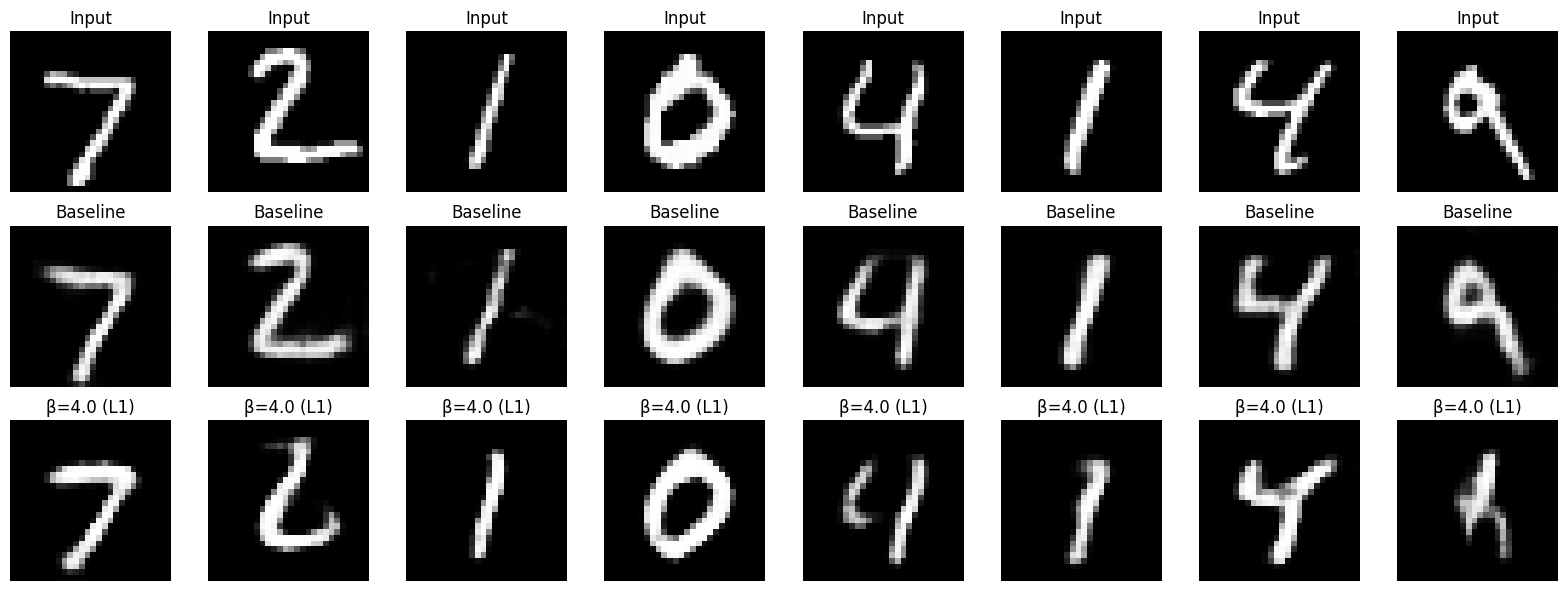

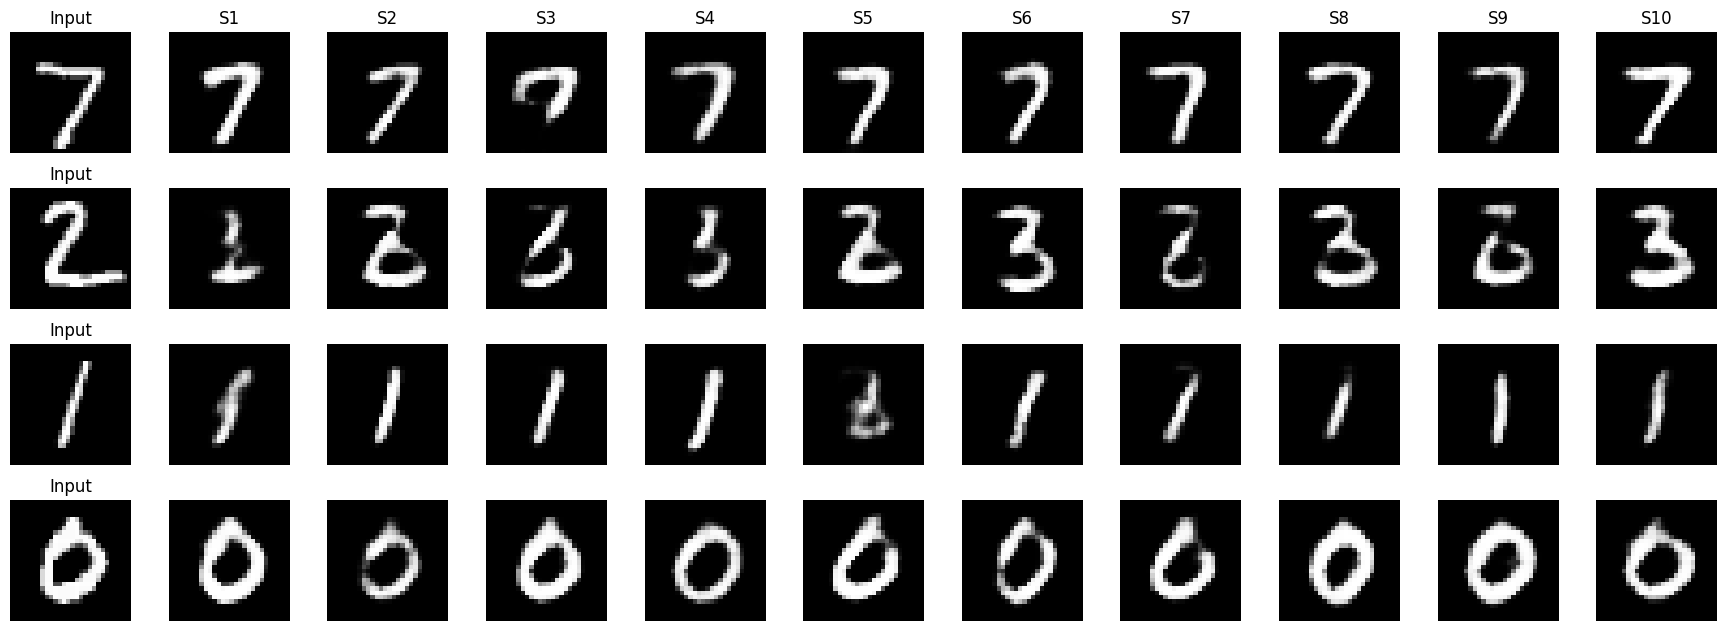

In [57]:
#------Visualise---------
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def compare_reconstructions_three(baseline_model, pert_model, loader, n=8):
    xb, _ = next(iter(loader))
    xb = xb[:n].to(DEVICE)
    base_rec, _, _ = baseline_model.eval()(xb)
    pert_rec, _, _ = pert_model.eval()(xb)

    fig, axes = plt.subplots(3, n, figsize=(2*n, 6))
    for i in range(n):
        axes[0,i].imshow(((xb[i,0].cpu()+1)/2).clamp(0,1), cmap='gray'); axes[0,i].set_title("Input"); axes[0,i].axis('off')
        axes[1,i].imshow(base_rec[i,0].cpu(), cmap='gray');            axes[1,i].set_title("Baseline"); axes[1,i].axis('off')
        axes[2,i].imshow(pert_rec[i,0].cpu(), cmap='gray');            axes[2,i].set_title("β=4.0 (L1)"); axes[2,i].axis('off')
    plt.tight_layout(); plt.show()

@torch.no_grad()
def show_multiple_samples(model, loader, n_images=4, n_samples=10):
    xb, _ = next(iter(loader))
    xb = xb[:n_images].to(DEVICE)
    fig, axes = plt.subplots(n_images, n_samples+1, figsize=(1.6*(n_samples+1), 1.6*n_images))
    for i in range(n_images):
        axes[i,0].imshow(((xb[i,0].cpu()+1)/2).clamp(0,1), cmap='gray'); axes[i,0].set_title("Input"); axes[i,0].axis('off')
        for j in range(n_samples):
            rec, _, _ = model.eval()(xb[i].unsqueeze(0))
            axes[i,j+1].imshow(rec[0,0].cpu(), cmap='gray'); axes[i,j+1].set_title(f"S{j+1}" if i==0 else ""); axes[i,j+1].axis('off')
    plt.tight_layout(); plt.show()

compare_reconstructions_three(vae_model, vae_beta_l1, test_loader)

show_multiple_samples(vae_beta4_l1, test_loader, n_images=4, n_samples=10)

# 3) Input Blur

### Phase A - Acute Blur (no retraining)

In [58]:
#---------A1) Helper: Fast Gaussian blur on a tensor batch----------------
import torch
import torch.nn.functional as F

def gaussian_kernel_1d(ksize=5, sigma=1.0, device="cpu", dtype=torch.float32):
    x = torch.arange(ksize, device=device, dtype=dtype) - (ksize-1)/2
    g = torch.exp(-(x**2)/(2*sigma**2))
    g = g / g.sum()
    return g

def gaussian_blur_batch(x, ksize=5, sigma=1.0):


    B, C, H, W = x.shape
    assert C == 1, "expects single-channel MNIST"
    device = x.device
    dtype = x.dtype

    g = gaussian_kernel_1d(ksize, sigma, device, dtype)
    gx = g.view(1,1,1,ksize)
    gy = g.view(1,1,ksize,1)

    # conv is linear; keep range in [-1,1]
    x_blur = F.conv2d(x, gx, padding=(0, ksize//2), groups=1)
    x_blur = F.conv2d(x_blur, gy, padding=(ksize//2, 0), groups=1)
    return x_blur


In [59]:
#----------A2) Evaluating baseline model with blurred inputs (no retraining)--------

blur_ks = 7
blur_sigma = 1.0
model_label = f"inputblurA_sigma{blur_sigma:.1f}"

@torch.no_grad()
def eval_with_blurred_inputs(model, loader, device, n_for_entropy_batches=50):
    # 1) Latent entropy on blurred inputs
    Hs = []
    batches = 0
    for x, _ in loader:
        x = x.to(device)
        xb = gaussian_blur_batch(x, ksize=blur_ks, sigma=blur_sigma)
        # model forward to get mu, logvar via your latent_entropy_dataset logic:
        # we’ll reuse that function by monkey-patching the input
        recon, mu, logvar = model.eval()(xb)

        break

# Use your existing helpers directly by wrapping the dataloader

def blurred_loader_wrapper(loader, ksize=7, sigma=1.0):
    for x, y in loader:
        yield gaussian_blur_batch(x, ksize=ksize, sigma=sigma), y

# Run metrics with blurred inputs but same models
test_loader_blur = blurred_loader_wrapper(test_loader, ksize=blur_ks, sigma=blur_sigma)

# Latent entropy
H_mean, H_sd = latent_entropy_dataset(vae_model.eval(), test_loader_blur, DEVICE, bins=50, max_batches=50)
save_metrics(new_run_id(f"{model_label}_latent_entropy"),
             model=model_label, metric="latent_entropy", H_mean=H_mean, H_sd=H_sd)
print(f"[{model_label}] Latent entropy: {H_mean:.3f} ± {H_sd:.3f}")

# Reconstruction variability (n_samples=30 for sensitivity)
rv_mean, rv_sd = reconstruction_variability(vae_model.eval(), test_loader_blur, DEVICE,
                                            n_images=64, n_samples=30)
save_metrics(new_run_id(f"{model_label}_RV"),
             model=model_label, metric="recon_variability", rv_mean=rv_mean, rv_sd=rv_sd)
print(f"[{model_label}] Recon variability: {rv_mean:.5f} ± {rv_sd:.5f}")

# Spectral slope β
beta_mean, beta_sd = spectral_slope_beta(vae_model.eval(), test_loader_blur, DEVICE, n_images=64, mode="baseline")
save_metrics(new_run_id(f"{model_label}_spectral_slope"),
             model=model_label, metric="spectral_slope_beta", beta_mean=beta_mean, beta_sd=beta_sd)
print(f"[{model_label}] Spectral slope β: {beta_mean:.4f} ± {beta_sd:.4f}")


[saved] inputblurA_sigma1.0_latent_entropy_20250829-034706 -> CSV + inputblurA_sigma1.0_latent_entropy_20250829-034706_metrics.json
[inputblurA_sigma1.0] Latent entropy: 3.329 ± 0.021
[saved] inputblurA_sigma1.0_RV_20250829-034707 -> CSV + inputblurA_sigma1.0_RV_20250829-034707_metrics.json
[inputblurA_sigma1.0] Recon variability: 0.02471 ± 0.00485
[saved] inputblurA_sigma1.0_spectral_slope_20250829-034707 -> CSV + inputblurA_sigma1.0_spectral_slope_20250829-034707_metrics.json
[inputblurA_sigma1.0] Spectral slope β: -4.0733 ± 0.2116


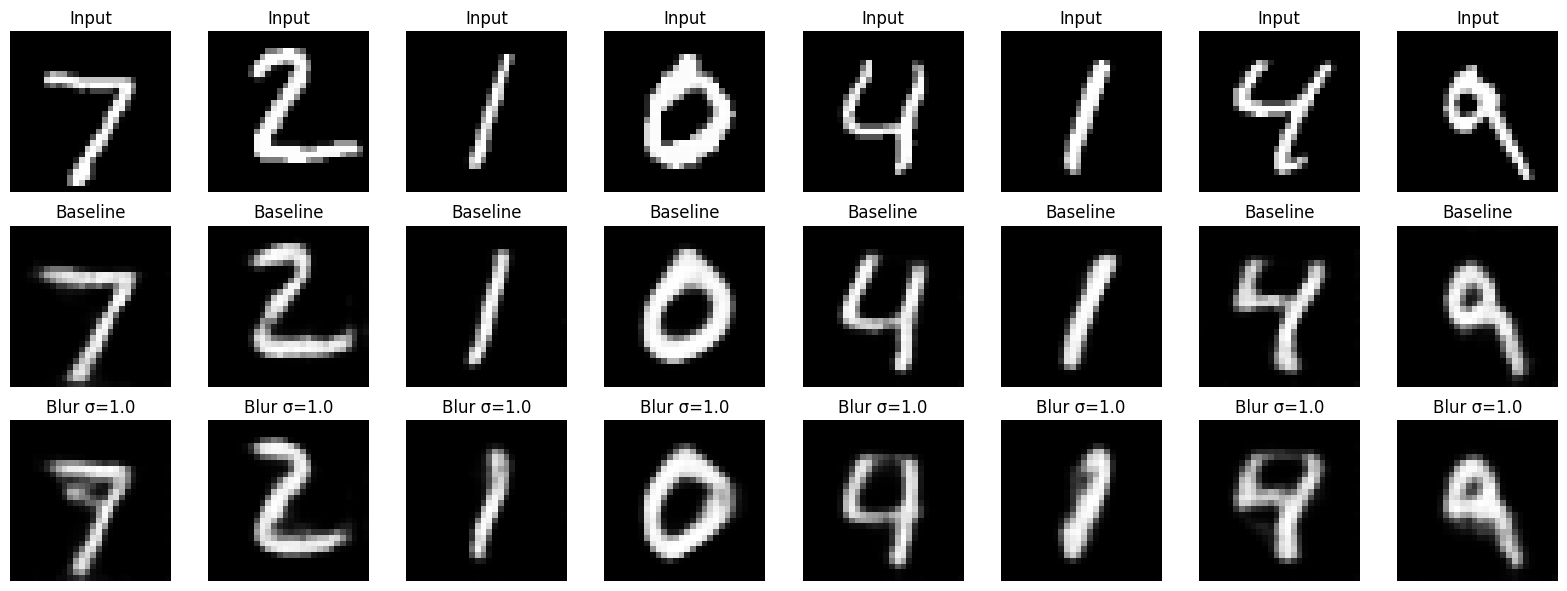

In [60]:
#--------A3) Visualization-------
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def compare_reconstructions_blur(baseline_model, loader, ksize=7, sigma=1.0, n=8):
    xb, _ = next(iter(loader))
    xb = xb[:n].to(DEVICE)
    # blurred inputs
    xblur = gaussian_blur_batch(xb, ksize=ksize, sigma=sigma)

    r_base, _, _ = baseline_model.eval()(xb)
    r_blur, _, _ = baseline_model.eval()(xblur)

    fig, axes = plt.subplots(3, n, figsize=(2*n, 6))
    for i in range(n):
        axes[0,i].imshow(((xb[i,0].cpu()+1)/2).clamp(0,1), cmap='gray');     axes[0,i].set_title("Input"); axes[0,i].axis('off')
        axes[1,i].imshow(r_base[i,0].cpu(), cmap='gray');                    axes[1,i].set_title("Baseline"); axes[1,i].axis('off')
        axes[2,i].imshow(r_blur[i,0].cpu(), cmap='gray');                    axes[2,i].set_title(f"Blur σ={sigma}"); axes[2,i].axis('off')
    plt.tight_layout(); plt.show()

# usage:
compare_reconstructions_blur(vae_model, test_loader, ksize=blur_ks, sigma=blur_sigma, n=8)


# Step 2: Collating all Results

In [61]:
import pandas as pd
import json

def load_all_metrics(results_dir=LOGS_DIR):
    rows = []
    for f in results_dir.glob("*.json"):
        with open(f, "r") as fp:
            data = json.load(fp)
        model = data.get("model", "unknown")
        metric = data.get("metric", "unknown")

        # pick out the key values depending on metric
        if metric == "latent_entropy":
            mean, sd = data["H_mean"], data["H_sd"]
        elif metric == "recon_variability":
            mean, sd = data["rv_mean"], data["rv_sd"]
        elif metric == "spectral_slope_beta":
            mean, sd = data["beta_mean"], data["beta_sd"]
        else:
            continue  # skip if unknown

        rows.append({
            "Model": model,
            "Metric": metric,
            "Mean": mean,
            "SD": sd
        })

    df = pd.DataFrame(rows)
    return df

# --- Load all saved results into one DataFrame ---
df_all = load_all_metrics()
print(df_all.head())

# --- Pivot to summary table ---
summary = df_all.pivot_table(
    index="Model",
    columns="Metric",
    values=["Mean","SD"]
)

summary

                 Model               Metric      Mean        SD
0  inputblurA_sigma1.0  spectral_slope_beta -4.073280  0.211612
1  inputblurA_sigma1.0    recon_variability  0.024713  0.004853
2          betaVAE_2.0  spectral_slope_beta -4.121257  0.172360
3          betaVAE_2.0       latent_entropy  3.329099  0.024600
4     latentnoise_0.30  spectral_slope_beta -4.084837  0.184567


Mean                                        \
Metric              latent_entropy recon_variability spectral_slope_beta   
Model                                                                      
baseline                  3.335256          0.010068           -3.719425   
betaVAE_2.0               3.329099          0.004821           -4.121257   
betaVAE_2.0_L1            3.334090          0.013443           -3.332801   
betaVAE_4.0_L1            3.333313          0.017329           -3.480635   
inputblurA_sigma1.0       3.329361          0.024713           -4.073280   
latentnoise_0.30          3.338649          0.004696           -4.084837   
latentnoise_1.0           3.345517          0.007482           -4.594612   

                                SD                                        
Metric              latent_entropy recon_variability spectral_slope_beta  
Model                                                                     
baseline                  0.019127          0.001921            0.242488  
betaVAE_2.0               0.024600          0.000770            0.172360  
betaVAE_2.0_L1            0.022101          0.003782            0.197281  
betaVAE_4.0_L1            0.027369          0.005235            0.219298  
inputblurA_sigma1.0       0.021151          0.004853            0.211612  
latentnoise_0.30          0.021165          0.000984            0.184567  
latentnoise_1.0           0.025311          0.002372            0.213791

# Step 2: Visual Summaries

/tmp/ipython-input-3547868881.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=30, ha="right")
/tmp/ipython-input-3547868881.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=30, ha="right")
/tmp/ipython-input-3547868881.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=30, ha="right")


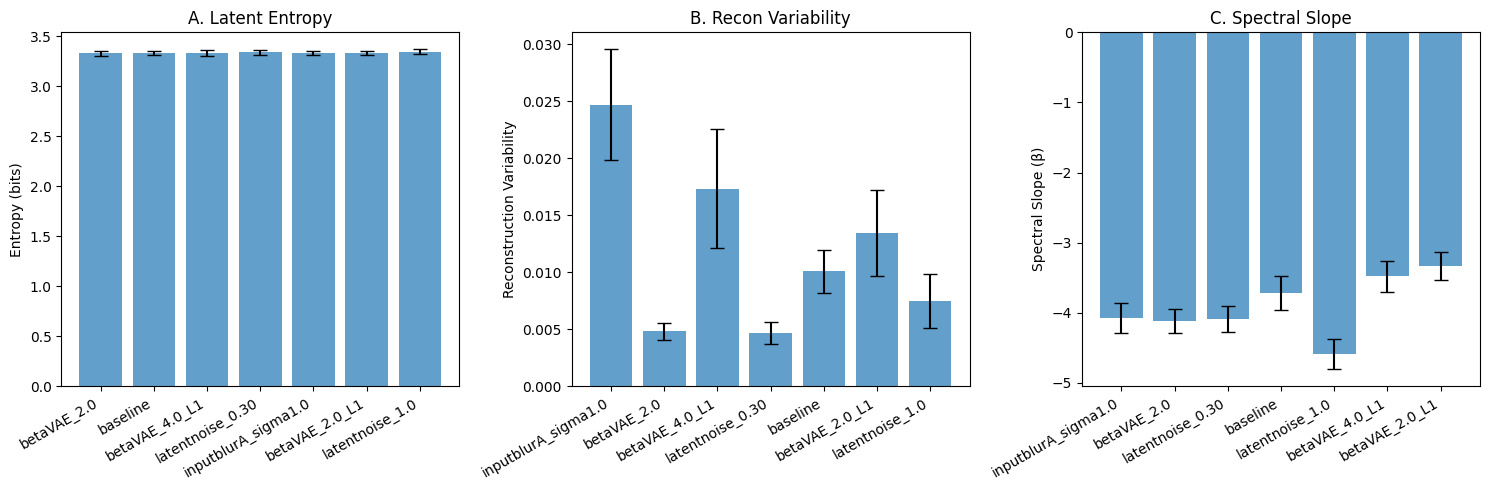

In [62]:
import matplotlib.pyplot as plt

def plot_all_metrics(df_all):
    metrics = [
        ("latent_entropy", "Entropy (bits)", "A. Latent Entropy"),
        ("recon_variability", "Reconstruction Variability", "B. Recon Variability"),
        ("spectral_slope_beta", "Spectral Slope (β)", "C. Spectral Slope")
    ]

    fig, axes = plt.subplots(1, 3, figsize=(15,5))

    for ax, (metric_name, ylabel, title) in zip(axes, metrics):
        df_metric = df_all[df_all["Metric"] == metric_name]

        models = df_metric["Model"].values
        means = df_metric["Mean"].values
        sds   = df_metric["SD"].values

        ax.bar(models, means, yerr=sds, capsize=5, alpha=0.7)
        ax.set_xticklabels(models, rotation=30, ha="right")
        ax.set_ylabel(ylabel)
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

# === Run combined plot ===
plot_all_metrics(df_all)


[saved] metrics_comparison_panels.png


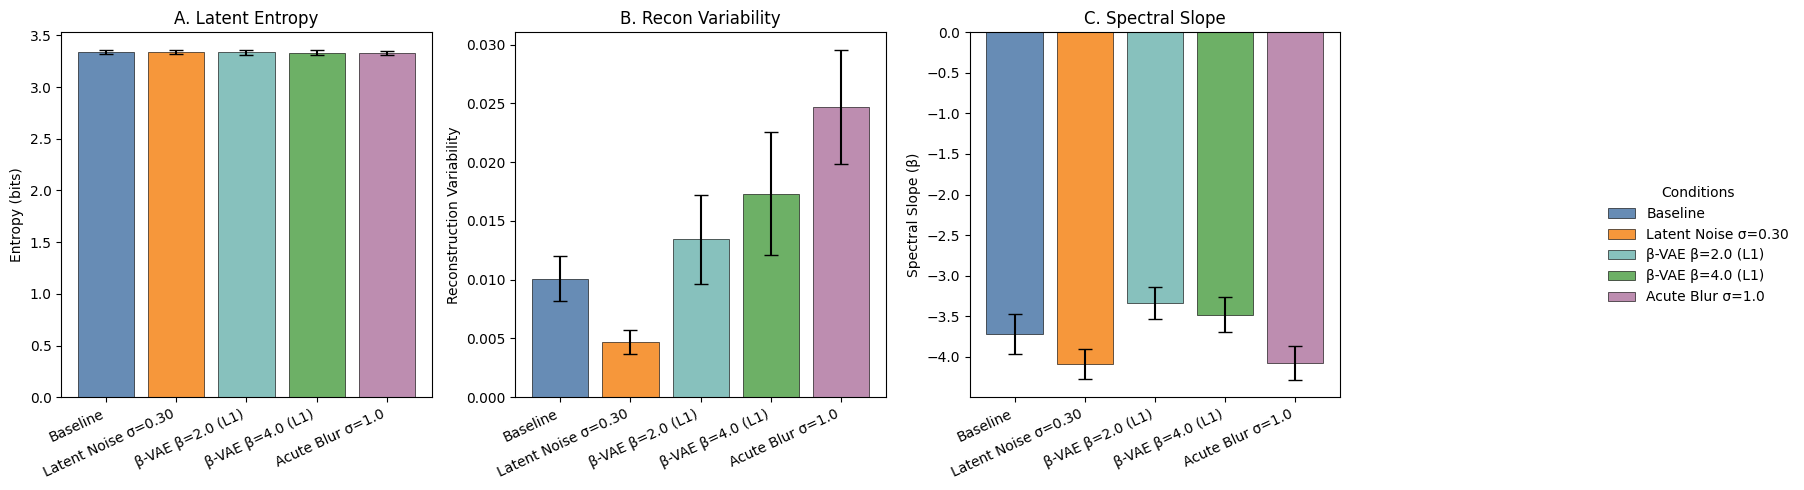

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Choose a consistent display order for models (edit if you ran different ones) ---
MODEL_ORDER = [
    "baseline",
    "latentnoise_0.30",
    "latentnoise_0.50",
    "betaVAE_2.0_L1",   # or betaVAE_2.0 if you didn’t do L1
    "betaVAE_4.0_L1",
    "inputblurA_sigma1.0",
]

# --- 2) Assign a consistent color per model label ---
COLOR_MAP = {
    "baseline":              "#4C78A8",  # blue
    "latentnoise_0.30":      "#F58518",  # orange
    "latentnoise_0.50":      "#E45756",  # red
    "betaVAE_2.0":           "#72B7B2",  # teal (fallback if not L1)
    "betaVAE_2.0_L1":        "#72B7B2",  # teal
    "betaVAE_4.0":           "#54A24B",  # green (fallback if not L1)
    "betaVAE_4.0_L1":        "#54A24B",  # green
    "inputblurA_sigma1.0":   "#B279A2",  # purple
}

# --- 3) Nice display names for axis (optional) ---
DISPLAY_NAME = {
    "baseline":              "Baseline",
    "latentnoise_0.30":      "Latent Noise σ=0.30",
    "latentnoise_0.50":      "Latent Noise σ=0.50",
    "betaVAE_2.0":           "β-VAE β=2.0",
    "betaVAE_2.0_L1":        "β-VAE β=2.0 (L1)",
    "betaVAE_4.0":           "β-VAE β=4.0",
    "betaVAE_4.0_L1":        "β-VAE β=4.0 (L1)",
    "inputblurA_sigma1.0":   "Acute Blur σ=1.0",
}

def plot_all_metrics_colored(df_all, save_path=None):
    metrics = [
        ("latent_entropy",      "Entropy (bits)",         "A. Latent Entropy"),
        ("recon_variability",   "Reconstruction Variability", "B. Recon Variability"),
        ("spectral_slope_beta", "Spectral Slope (β)",     "C. Spectral Slope"),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # Build a legend once (unique handles)
    legend_items = []

    for ax, (metric_name, ylabel, title) in zip(axes, metrics):
        df_metric = df_all[df_all["Metric"] == metric_name].copy()

        # Keep only models that exist in df_all and respect MODEL_ORDER
        ordered_models = [m for m in MODEL_ORDER if m in df_metric["Model"].values]
        means = []
        sds = []
        colors = []
        labels = []
        for m in ordered_models:
            row = df_metric[df_metric["Model"] == m]
            if row.empty:
                continue
            means.append(float(row["Mean"].values[0]))
            sds.append(float(row["SD"].values[0]))
            colors.append(COLOR_MAP.get(m, "#999999"))
            labels.append(DISPLAY_NAME.get(m, m))

        x = np.arange(len(labels))
        bars = ax.bar(x, means, yerr=sds, capsize=5, alpha=0.85, color=colors, edgecolor="black", linewidth=0.5)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=25, ha="right")
        ax.set_ylabel(ylabel)
        ax.set_title(title)

        # Capture legend handles just once (first panel)
        if not legend_items:
            legend_items = [(bars[i], labels[i]) for i in range(len(labels))]

    # Build legend (outside right)
    handles, texts = zip(*legend_items)
    fig.legend(handles, texts, loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False, title="Conditions")

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[saved] {save_path}")
    plt.show()

# --- Run it; also save a PNG for your dissertation ---
plot_all_metrics_colored(df_all, save_path="metrics_comparison_panels.png")


### Build Results Dicts and Exporting CSV with CIs

In [64]:
# --- Run MNIST baseline + sweeps and export CSV with 95% CIs ---
# Baseline
res_base_mnist = mnist_run_metrics(vae_model.eval(), test_loader, mode="baseline", n_eval=2000, K_var=10)

# Latent-noise sweep (match CIFAR scales so the tables align)
noise_scales = [0.75, 1.25, 1.5, 2.0, 2.5]
res_noise_mnist = {}
for s in noise_scales:
    res_noise_mnist[s] = mnist_run_metrics(vae_model.eval(), test_loader, mode="latent_noise", param=s, n_eval=1500, K_var=10)

# Beta-like sweep
beta_like_settings = [(0.85, 1.25), (0.70, 1.60)]
res_beta_mnist = {}
for p in beta_like_settings:
    res_beta_mnist[p] = mnist_run_metrics(vae_model.eval(), test_loader, mode="beta_like", param=p, n_eval=1500, K_var=10)

# Input blur sweep
blur_sigmas = [1.0, 1.4, 2.0]
res_blur_mnist = {}
for sig in blur_sigmas:
    res_blur_mnist[sig] = mnist_run_metrics(vae_model.eval(), test_loader, mode="input_blur", param=sig, n_eval=1500, K_var=10)

# ---- Summarise + CSV (same fields as CIFAR) ----
import csv, os
os.makedirs("./exports", exist_ok=True)

def _summarise_block(tag, res_dict, x_formatter=str, rows=None):
    if rows is None: rows = []
    for k, r in res_dict.items():
        Hm, Hlo, Hhi = mean_and_ci(r["latent_entropy"])
        RVm, RVlo, RVhi = mean_and_ci(r["recon_var"])
        Am, Alo, Ahi = mean_and_ci(r["spectral_alpha"])
        rows.append({
            "group": tag,
            "param": x_formatter(k),
            "H_mean": Hm, "H_lo": Hlo, "H_hi": Hhi,
            "RV_mean": RVm, "RV_lo": RVlo, "RV_hi": RVhi,
            "alpha_mean": Am, "alpha_lo": Alo, "alpha_hi": Ahi,
        })
    return rows

rows = []
rows = _summarise_block("baseline", {"baseline": res_base_mnist}, x_formatter=lambda k: k, rows=rows)
rows = _summarise_block("latent_noise", res_noise_mnist, x_formatter=lambda k: f"{float(k):.2f}", rows=rows)
rows = _summarise_block("beta_like", res_beta_mnist, x_formatter=lambda k: f"mu*{k[0]:.2f}_std/{k[1]:.2f}", rows=rows)
rows = _summarise_block("input_blur", res_blur_mnist, x_formatter=lambda k: f"{float(k):.2f}", rows=rows)

out_csv = "./exports/mnist_metrics_summary.csv"
with open(out_csv, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    w.writeheader(); w.writerows(rows)
print(f"✓ Saved: {out_csv}")

✓ Saved: ./exports/mnist_metrics_summary.csv
